# Wood Berry's Distillation Column - System Analysis

All needed information for controller design of Rosenbrocks system

In [7]:
# Import the needed packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import pandas as pd
import control as cn
import paperfunction as pf

# Set Plot Style
plt.style.use('seaborn-paper')

## System evaluation

Compute the poles and zeros of the multivariable control system.

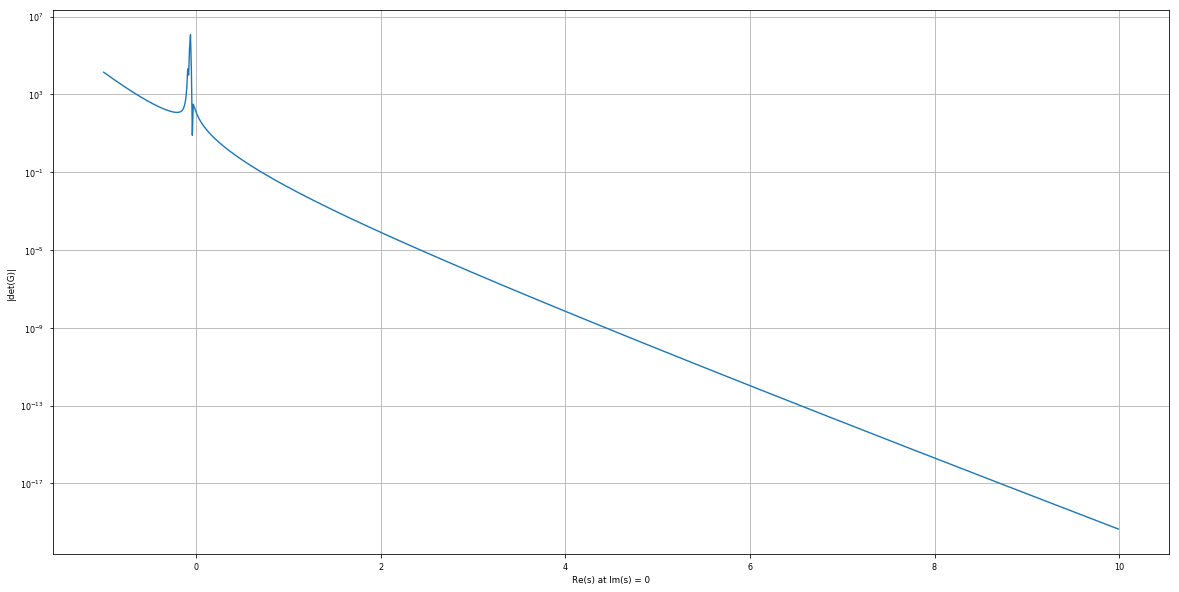

In [14]:
# Get the determinant
detG = lambda s : 12.8/(16.7*s+1.)*np.exp(-1.*s) * -19.4/(14.4*s+1)*np.exp(-3.0*s) + 6.6 / (10.9 * s + 1.) * np.exp(-7.*s) * 18.9 / (21.0 *s + 1.)* np.exp(-3.0*s)
detG = np.vectorize(detG)
# Make an array for s
s = np.arange(-1., 10, 0.01)


# Make a figure
plt.clf()
fig, ax = plt.subplots(figsize=(20, 10))
ax.semilogy(s, np.abs(detG(s)))
ax.grid(True)
ax.set_xlabel('Re(s) at Im(s) = 0')
ax.set_ylabel('|det(G)|')
plt.show()

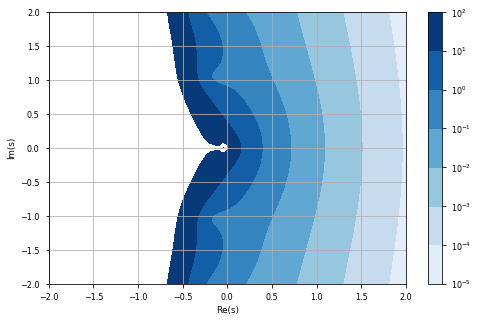

In [20]:
# Get the determinant as an absolute value, complex values as integers
detG = lambda x,y : np.abs(12.8/(16.7*(x+1j*y)+1.)*np.exp(-1.*(x+1j*y)) * -19.4/(14.4*(x+1j*y)+1)*np.exp(-3.0*(x+1j*y)) + 6.6 / (10.9 * (x+1j*y) + 1.) * np.exp(-7.*(x+1j*y)) * 18.9 / (21.0 *(x+1j*y) + 1.)* np.exp(-3.0*(x+1j*y)))
# Vectorize the function
detG = np.vectorize(detG)
# Make an quadratic meshgrid
x = np.arange(-2.,2,0.01)
X,Y = np.meshgrid(x,x)
# Compute the determinant
Z = detG(X,Y)
# Check where the machine precision is reached
loc = np.where(Z< np.finfo(float).eps)

# Plot
plt.clf()
fig, ax = plt.subplots(1,figsize=(8,5))
ax.contour(X,Y,detG(X,Y), levels = [0], colors = 'k')
# Determinant
cs = ax.contourf(X,Y,detG(X,Y),levels = np.logspace(-5,2,8), norm = colors.LogNorm() , cmap = cm.Blues)
cbar = fig.colorbar(cs)
# Machine Precision, remove limits for visibility
ax.scatter(X[loc], Y[loc], color = 'r')
ax.grid(True)
ax.set_xlabel('Re(s)')
ax.set_ylabel('Im(s)')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.show()

## Static Decoupling

Next, the model reduction via the dynamic decoupler is performed. The functions are given to be:

$g^*_{S,11} = \frac{12.8}{16.7~s+1}e^{-1.0s} - \frac{6.6}{19.4}~\frac{18.9}{21.0~s+1}e^{-3.0~s}$

and

$g^*_{S,22} = \frac{-19.4}{14.4~s+1}e^{-3.0s} + \frac{18.9}{12.8}~\frac{6.60}{10.9~s+1}e^{-7.0~s}$

The minimum time delay is given as : $L_{11}^* = 1.$ and $L_{22}^* = 3.$

Which leaves the delay free model:

$g_{11}^+ = \frac{12.8}{16.7~s+1} - \frac{6.6}{19.4}~\frac{18.9}{21.0~s+1}$

$g^+_{22} = \frac{-19.4}{14.4~s+1}+ \frac{18.9}{12.8}~\frac{6.60}{10.9~s+1}$

[ 12.35963748] [ 37.50230562]


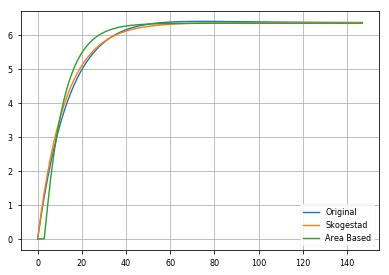

Without Minimal Delay
Skogestad :  6.37010309278 12.3596374818 0.0
Area :  6.35311641884 8.50386679315 3.09447206455


In [22]:
# G11
# Get the real , delay free system
g = cn.tf([12.8],[16.7,1.]) - 6.6 / 19.4 * cn.tf([18.9],[21.,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

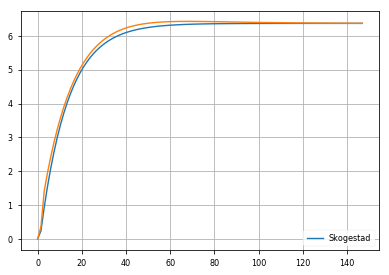

With Minimal Delay
Skogestad :  6.37010309278 12.3596374818 1.0


In [24]:
# Show the real system response
# Delay free addend
g1 = cn.tf(12.8, [16.7,1])
g2 = - 6.6 / 19.4 * cn.tf([18.9],[21.,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t, y1+y2)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad : ", K, T, L+1)

[ 17.93285321] [ 24.84603806]


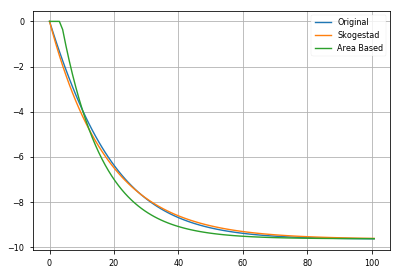

Without Minimal Delay
Skogestad :  -9.6546875 17.9328532125 0.0
Area :  -9.63508467992 12.6615747929 3.58867672893


In [25]:
# G22
# Get the real , delay free system
g = cn.tf([-19.4],[14.4,1.]) +18.9/12.8 * cn.tf([6.6],[10.9,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

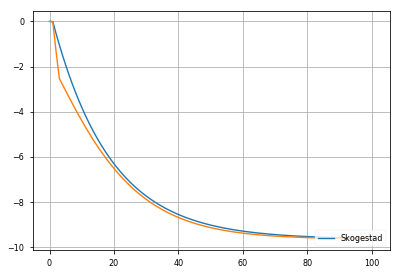

With Minimal Delay
Skogestad :  -9.6546875 17.9328532125 3.0


In [26]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-19.4],[14.4,1.])
g2 = 18.9/12.8 * cn.tf([6.6],[10.9,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t, y1+y2)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("With Minimal Delay")
print("Skogestad : ", K, T, L+3)

## Dynamic Decoupling

The transfer functions, with the same external time delay,  are given to be

$g_{11}^+ = \frac{12.8}{16.7~s+1} - \frac{6.6}{19.4}~\frac{14.4~s+1}{10.9~s+1}~\frac{18.9}{21.0~s+1}$

$g^+_{22} = \frac{-19.4}{14.4~s+1}+ \frac{18.9}{12.8}~\frac{16.7~s+1}{21.0~s+1}~\frac{6.60}{10.9~s+1}$

[ 15.89249069] [  24.61490993 -370.60139156]


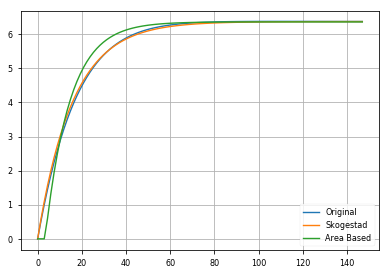

Without Minimal Delay
Skogestad :  6.37010309278 15.8924906943 0.0
Area :  6.3596143862 11.1524179502 3.36517465785


In [27]:
# G11
# Get the real , delay free system
g = cn.tf([12.8],[16.7,1.]) - 6.6 / 19.4 * cn.tf([18.9],[21.,1]) *cn.tf([14.4,1],[10.9,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

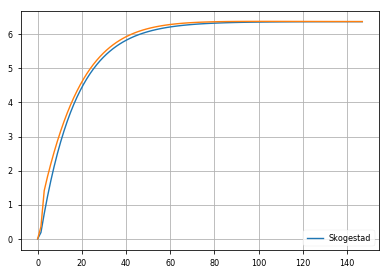

Without Minimal Delay
Skogestad :  6.37010309278 15.8924906943 1.0


In [28]:
# Show the real system response
# Delay free addend
g1 = cn.tf([12.8],[16.7,1.])
g2 = - 6.6 / 19.4 * cn.tf([18.9],[21.,1]) *cn.tf([14.4,1],[10.9,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t, y1+y2)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L+1)

[ 13.59249069] [  26.47218133 -343.717388  ]


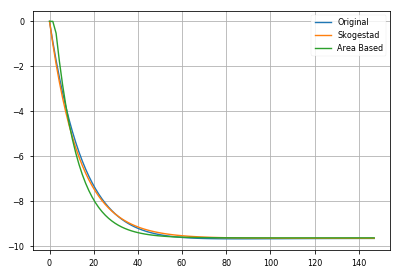

Without Minimal Delay
Skogestad :  -9.6546875 13.5924906943 0.0
Area :  -9.63499706308 10.1251997474 2.40003377042


In [29]:
# G22
# Get the real , delay free system
g = cn.tf([-19.4],[14.4,1.]) +18.9/12.8 * cn.tf([6.6],[10.9,1]) *cn.tf([16.7,1],[21.0,1])
# Get the static gain
K = cn.dcgain(g)[0,0]
# Normalize the transfer function
g_Norm = 1/K * g
# Get the numerator and denominator of the SISO function
num = g_Norm.num[0][0]
den = g_Norm.den[0][0]
# Get the roots, -1/T_1, -1/T_2 ...
num = np.roots(num)
den = np.roots(den)
# Get the Time Constants
num = -1./num
den = -1./den

# Model Approximation via Skogestadt
T,L = pf.MODEL_TO_FOTD(num, den)

y, t = cn.step(g)
yM = pf.Simulate_FOPTD(float(K),float(T),float(L), t)

# Area Identification
k2,t2,l2 = pf.FOTD_AREA_IDENTIFICATION(y,1.,t)
yM2 = pf.Simulate_FOPTD(float(k2),float(t2),float(l2),t)
plt.plot(t,y, label = "Original")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t,yM2, label = "Area Based")
plt.legend(loc = "upper right")
plt.grid(True)
plt.show()

print("Without Minimal Delay")
print("Skogestad : ", K, T, L)
print("Area : ", k2, t2, l2)

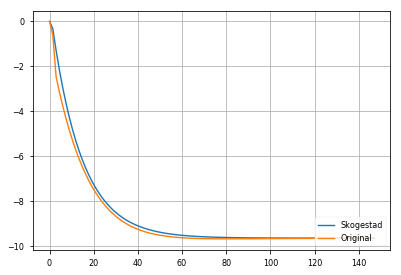

With Minimal Delay
Skogestad :  -9.6546875 13.5924906943 3.0


In [32]:
# Show the real system response
# Delay free addend
g1 = cn.tf([-19.4],[14.4,1.])
g2 = 18.9/12.8 * cn.tf([6.6],[10.9,1]) *cn.tf([16.7,1],[21.0,1])
gM = cn.tf(K,[T,1])
# Simulate the step responses with a fixed time
y1, t1 = cn.step(g1, t)
y2, t2 = cn.step(g2, t)
yM, tM = cn.step(gM, t)
# Add the delay, use the same time values 
y1, t = pf.Time_Delay(1., y1, t1, t)
y2, t = pf.Time_Delay(3., y2, t2, t)
yM, t = pf.Time_Delay(L+1., yM, tM, t)

# Plot
#plt.plot(t,y1, label = "Original 1")
#plt.plot(t,y2, label = "Original 2")
plt.plot(t,yM, label = "Skogestad")
plt.plot(t, y1+y2, label = "Original")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()
print("With Minimal Delay")
print("Skogestad : ", K, T, L+3)

## Simulation

Simulate the dymola systems via the interface.

In [16]:
# General Information

# Modelica Package name
Package = "WoodBerry"

# Make an array of models to automate the evaluation
models = ['Ideal','Decentralized', 'Static_Decoupling', 'Dynamic_Decoupling', 'Centralized_PID']

# Model to simulate, here the folder and the modelica file containing the model needs to be specified.
Model_Path = "../Modelica/Rosenbrock.mo"

# Simulation Parameter, here the simulation parameter have to be specified.
sim_parameter = {
    "stopTime" : 4600,
    "Intervals": 1e2,
    "OutputInterval" : 1,
    "Stepsize" : 1,
    "finalNames" : ["y_1","y_2","u_1","u_2", "IAE_1.y", "IAE_2.y", "IE_1", "IE_2"],
}


### System Analysis

Analyze the system without gains.

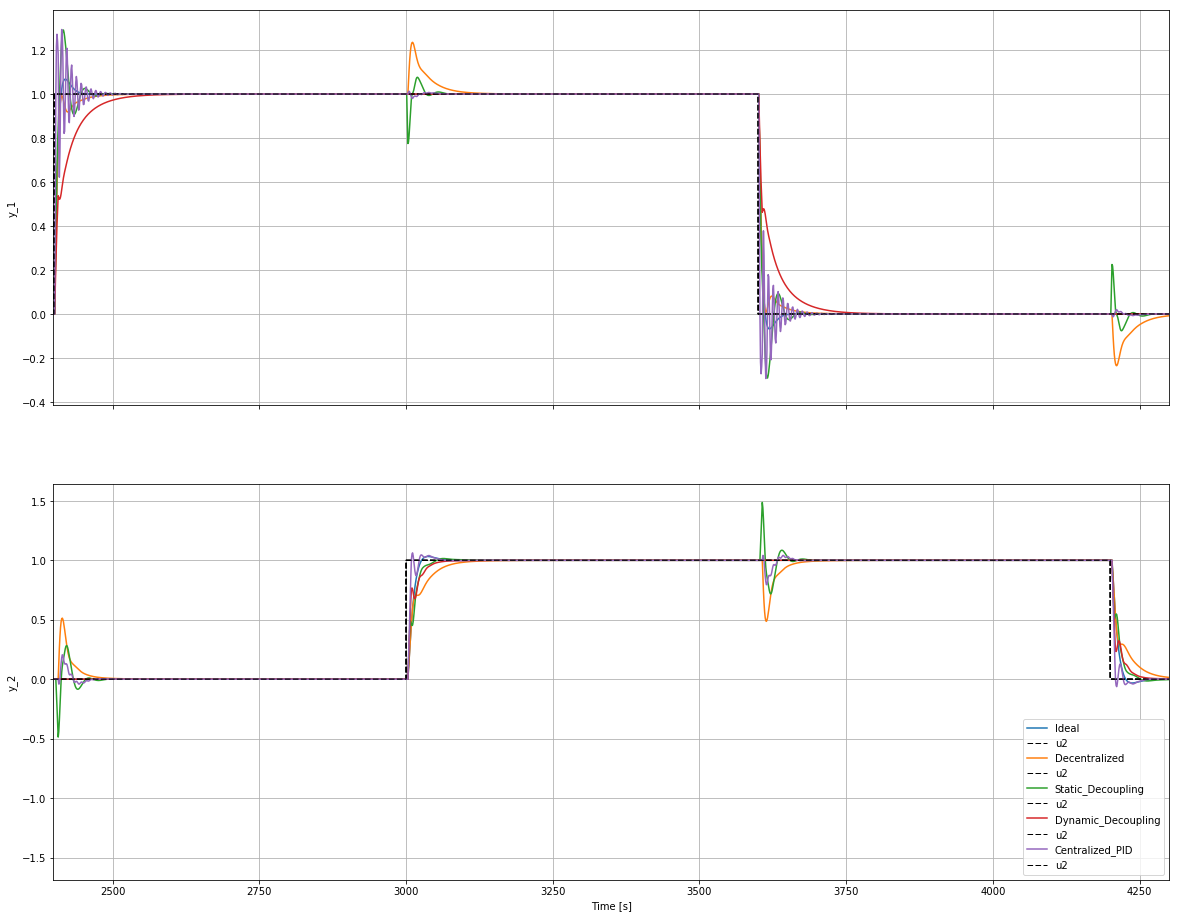

In [17]:
# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo", Show = False)

# Make a plot
plt.clf()
fig, ax = plt.subplots(2, sharex = True, figsize = (20,16))

# Loop over all models in the modelica file
for model_names in models:

    # Update the simulation parameter
    sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names})
    # Run the current simulation
    pf.Run_Simulation(model, sim_parameter)
    # Get the result data
    Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+".mat")
    # Apply the data to the plot
    ax[0].plot(Data["time"], Data["y1"], label = model_names)
    ax[0].plot(Data["time"], Data["u1"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)
    
    ax[1].plot(Data["time"], Data["y2"], label = model_names)
    ax[1].plot(Data["time"], Data["u2"], color = 'k', linewidth = 1, linestyle = 'dashed', label = None)

# Close the current simulation instance
model.close()

# Add the layout to the plot
ax[1].legend()
ax[0].set_ylabel('y_1')
ax[0].grid(True)
ax[1].set_ylabel('y_2')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)
ax[0].set_xlim([2399,4301])
plt.show()

### Gain Study for Decentralized system

Decentralized controlled system;

Steps to be taken:
- Get the system behaviour without additional gain
- Amplify every gain K_11 / K_22 individually until the closed loop collapses
- Amplify both gains until the closed loop collapses

In [19]:
# Gain Increment and maximum Gain
dK = .1
KMax = 70

# Initialize the model
model = pf.Initialize_Simulation("../Modelica/"+Package+".mo")

# Make a list for gain storage
maximum_gains = {}

# Loop over all models in the modelica file except "Ideal"
for model_names in models[1:]:
    
    # Inner loop, increase the gain of u_1
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K11"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[K,1.]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K11.mat")
        # Check the stability
        stability = pf.Stability(Data["y1"].values,Data["u1"].values) and pf.Stability(Data["y2"].values,Data["u2"].values)


    # Get the last stable gain
    maximum_gains.update({model_names+"_K11" : K-dK})
    
    # Inner loop, increase the gain of u_2
    # Make the gains
    K = 1.
    # Start with stable system
    stability = True
    
    while stability:
        # Increase the gain
        if (K < KMax):
            K = K + dK
        else:
            break
        # Update the simulation parameter
        sim_parameter.update({"Model":Package+"."+model_names, "Result": "../Data/"+Package+"/"+model_names+"_K22"})
        sim_parameter.update({"initialNames":["K_11.k", "K_22.k"], "initialValues":[1.,K]})
        # Simulate the model
        pf.Run_Simulation(model, sim_parameter)
        # Load the results
        Data = pf.Simulation_Results("../Data/"+Package+"/"+model_names+"_K22.mat")
        # Check the stability
        stability = pf.Stability(Data["y1"].values,Data["u1"].values) and pf.Stability(Data["y2"].values,Data["u2"].values)
    # Get the last stable gain
    maximum_gains.update({model_names+"_K22" : K-dK})

# Close the model
model.close()    

0

In [20]:
maximum_gains

{'Centralized_PID_K11': 2.5000000000000013,
 'Centralized_PID_K22': 1.4000000000000004,
 'Decentralized_K11': 8.899999999999986,
 'Decentralized_K22': 4.999999999999999,
 'Dynamic_Decoupling_K11': 8.499999999999988,
 'Dynamic_Decoupling_K22': 3.400000000000002,
 'Static_Decoupling_K11': 3.500000000000002,
 'Static_Decoupling_K22': 8.399999999999988}